## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [11]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

# QUESTION 1

In [12]:
filename= "/Users/chime/Documents/LaboratoryOfComputationalPhysics/data/data_000637.txt"
##Full reading
Data = np.genfromtxt(filename, dtype='float64', delimiter=',', skip_header=1)

##Reading N rows
#N=10000
#Data = np.genfromtxt(filename, delimiter=',', skip_header=1, max_rows=N)

df = pd.DataFrame(Data, index=np.arange(len(Data)), columns=['HEAD','FPGA','TDC_CHANNEL','ORBIT_CNT','BX_COUNTER', 'TDC_MEAS'])
display(df)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1.0,0.0,123.0,3.869200e+09,2374.0,26.0
1,1.0,0.0,124.0,3.869200e+09,2374.0,27.0
2,1.0,0.0,63.0,3.869200e+09,2553.0,28.0
3,1.0,0.0,64.0,3.869200e+09,2558.0,19.0
4,1.0,0.0,64.0,3.869200e+09,2760.0,25.0
5,1.0,0.0,63.0,3.869200e+09,2762.0,4.0
6,1.0,0.0,61.0,3.869200e+09,2772.0,14.0
7,1.0,0.0,139.0,3.869200e+09,2776.0,0.0
8,1.0,0.0,62.0,3.869200e+09,2774.0,21.0
9,1.0,0.0,60.0,3.869200e+09,2788.0,7.0


# QUESTION 2

In [13]:
x=df['BX_COUNTER'].max()
print('The value of x is:', x)

The value of x is: 3563.0


# QUESTION 3 SBAGLIATOOOOOOOO

In [14]:
max_time=(df['ORBIT_CNT'].max()-df['ORBIT_CNT'].min())*x*25
print('The full time data taking is:', max_time*10**(-9),'s')

The full time data taking is: 0.9801813 s


# QUESTION 4

0    3.446490e+14
1    3.446490e+14
2    3.446490e+14
3    3.446490e+14
4    3.446490e+14
Name: time_ns, dtype: float64

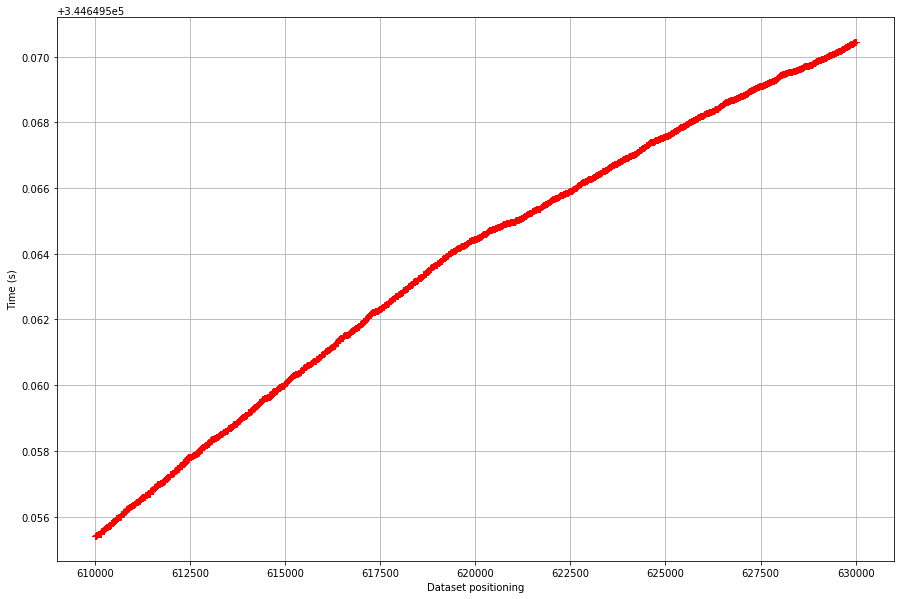

In [24]:
df['time_ns']=(df['TDC_MEAS'])*25/30+(df['BX_COUNTER'])*25+(df['ORBIT_CNT'])*25*x
#Displaying time series
display(df['time_ns'].head())
plt.figure(figsize=(15,10)); 
plt.xlabel('Dataset positioning')
plt.ylabel('Time (s)')
plt.plot(np.arange(start=610000,stop=630000,step=1), df['time_ns'][610000:630000]*10**(-9), 'r+'); 
plt.grid()
plt.show()

# QUESTION 5

In [16]:
df.loc[:,'HEAD']=np.around(np.random.rand(len(df['HEAD'])))
#Print example
display(df['HEAD'][0:10])

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: HEAD, dtype: float64

# QUESTION 6 

In [17]:
df2=df[df['HEAD']==1]

# QUESTION 7

(461629, 7)
(194112, 7)


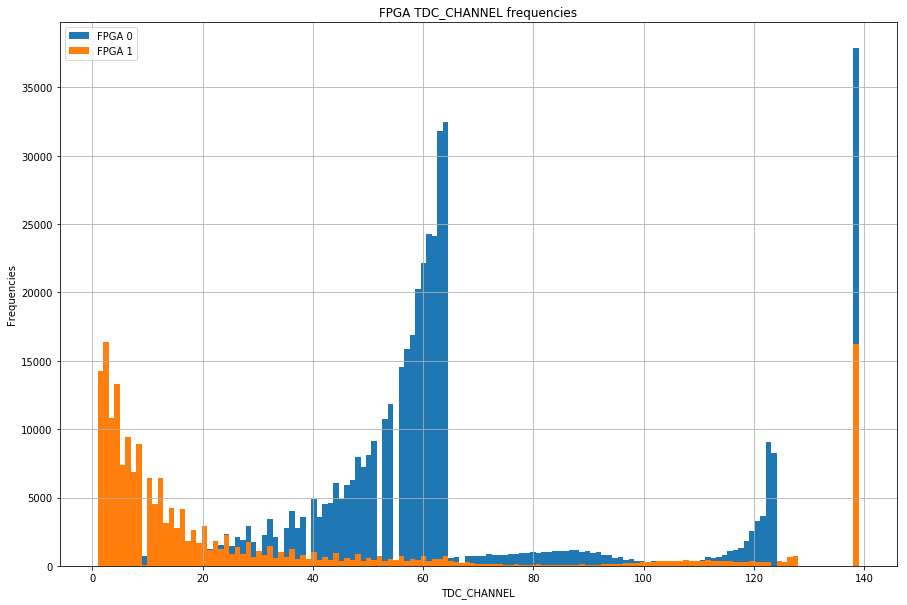

In [18]:
#df_FPGA0=df2[df2['FPGA']==0]
#df_FPGA1=df2[df2['FPGA']==1]
print(df2[df2['FPGA']==0].shape)
print(df2[df2['FPGA']==1].shape)

fig, ax=plt.subplots(figsize=(15,10))
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Frequencies')
df2.groupby('FPGA').hist(column='TDC_CHANNEL',bins=int(df2['TDC_CHANNEL'].max()),ax=ax)
plt.legend(['FPGA 0','FPGA 1'])
plt.title('FPGA TDC_CHANNEL frequencies')
plt.show()

# QUESTION 8

Noise FPGA0
      TDC_CHANNEL    CNT
122        139.0  37856
57          64.0  32437
56          63.0  31791
Noise FPGA1
      TDC_CHANNEL    CNT
1            2.0  16348
131        139.0  16244
0            1.0  14236


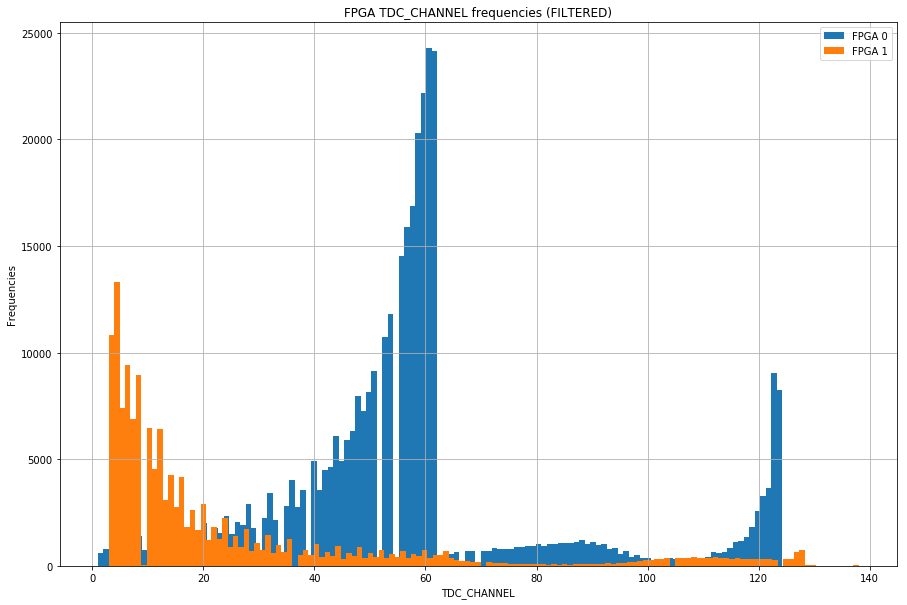

In [19]:
cnt=df2.groupby(['FPGA','TDC_CHANNEL']).size()

df_count_FPGA0=pd.DataFrame(cnt[0].index.values,columns=['TDC_CHANNEL']); df_count_FPGA0['CNT']=cnt[0].values
df_count_FPGA1=pd.DataFrame(cnt[1].index.values,columns=['TDC_CHANNEL']); df_count_FPGA1['CNT']=cnt[1].values

largest_0=df_count_FPGA0.nlargest(3,'CNT')
largest_1=df_count_FPGA1.nlargest(3,'CNT')
print('Noise FPGA0\n',largest_0)
print('Noise FPGA1\n',largest_1)

df2_0=df2[df2['FPGA']==0]
df2_1=df2[df2['FPGA']==1]

for i in np.arange(3):
    df2_0=df2_0.drop(df2_0[df2_0['TDC_CHANNEL']==largest_0['TDC_CHANNEL'][largest_0.index.values[i]]].dropna(how='any').index)
    df2_1=df2_1.drop(df2_1[df2_1['TDC_CHANNEL']==largest_1['TDC_CHANNEL'][largest_1.index.values[i]]].dropna(how='any').index)

fig, ax=plt.subplots(figsize=(15,10))
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Frequencies')
df2_0.hist(column='TDC_CHANNEL',bins=int(df2['TDC_CHANNEL'].max()),ax=ax)
df2_1.hist(column='TDC_CHANNEL',bins=int(df2['TDC_CHANNEL'].max()),ax=ax)
plt.legend(['FPGA 0','FPGA 1'])
plt.title('FPGA TDC_CHANNEL frequencies (FILTERED)')
plt.show()

# QUESTION 9 

In [20]:
unique_orbits=pd.DataFrame(df['ORBIT_CNT'].unique())
print('The number of unique orbits is:' , len(unique_orbits))

unique_orbits_TDC139=pd.DataFrame(df[df['TDC_CHANNEL']==139]['ORBIT_CNT'].unique())
print('The number of unique orbits with at least one measurement on channel 139 is:' , len(unique_orbits_TDC139))

The number of unique orbits is: 11001
The number of unique orbits with at least one measurement on channel 139 is: 10976
